In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.linalg as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from itertools import product
import torch.nn.functional as F

sns.set_style('whitegrid')

sns.set_context('notebook')

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 200

dev = 'cuda'

In [3]:
from utils import *
from embed import *
from tqdm import tqdm
from distance import *
models = ["wr-4-8", "allcnn-96-144", "fc-1024-512-256-128"]
opts = ["adam", "sgdn", "sgd"]

In [5]:
loc = 'results/models/new'
d = load_d(loc, cond={'aug': [True], 'm': models, 'opt':opts, 'wd':[0.0], 'bn':[True], 'bs':[200], },
        avg_err=True, drop=0.0, probs=True)

results/models/new/{"seed":42,"m":"allcnn-96-144","opt":"adam","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":42,"m":"allcnn-96-144","opt":"sgd","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":42,"m":"allcnn-96-144","opt":"sgdn","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":42,"m":"fc-1024-512-256-128","opt":"adam","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":42,"m":"fc-1024-512-256-128","opt":"sgd","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":42,"m":"fc-1024-512-256-128","opt":"sgdn","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":42,"m":"wr-4-8","opt":"adam","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":42,"m":"wr-4-8","opt":"sgd","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":42,"m":"wr-4-8","opt":"sgdn"

results/models/new/{"seed":49,"m":"wr-4-8","opt":"sgd","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":49,"m":"wr-4-8","opt":"sgdn","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":50,"m":"allcnn-96-144","opt":"adam","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":50,"m":"allcnn-96-144","opt":"sgd","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":50,"m":"allcnn-96-144","opt":"sgdn","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":50,"m":"fc-1024-512-256-128","opt":"adam","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":50,"m":"fc-1024-512-256-128","opt":"sgd","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":50,"m":"fc-1024-512-256-128","opt":"sgdn","lr":0.01,"wd":0.0,"bn":true,"aug":true,"bs":200}.p 20
results/models/new/{"seed":50,"m":"wr-4-8","opt":"adam"

In [10]:
yhs = np.stack(d['yh'].values).reshape(-1, 10)

In [41]:
init=np.stack(d[d['t'] == 0]['yh'].values)
p = np.sqrt(np.repeat(init, 20, axis=0)).reshape(-1, 10)

In [44]:
ds = get_data()['train']
y_ = np.array(ds.targets, dtype=np.int32)
y = np.zeros((y_.size, y_.max()+1))
y[np.arange(y_.size), y_] = 1
q = np.sqrt(np.repeat(np.expand_dims(y, axis=0), 1800, axis=0)).reshape(-1, 10)

In [47]:
def projection(r, p, q, debug=False):
    # r, p, q shape (npoints, ndim)
    if debug:
        assert np.allclose((r**2).sum(1), (p**2).sum(1), (q**2).sum(1), 1)
    cost, cost1, cost2 = (p*q).sum(1), (p*r).sum(1), (q*r).sum(1)
    tan = cost2/(cost1*np.sqrt(1-cost**2)) - cost / np.sqrt(1-cost**2)
    lam = (np.arctan(tan) * (tan > 0)) / np.arccos(cost)
    lam[lam > 1] = 1
    return lam

In [49]:
lams = projection(yhs, p, q)

In [51]:
lams = lams.reshape(1800, -1)

In [91]:
d['std'] = np.std(lams, axis=1)
d_ = d[]

In [95]:
idxs = d_.groupby(['m', 'opt']).indices

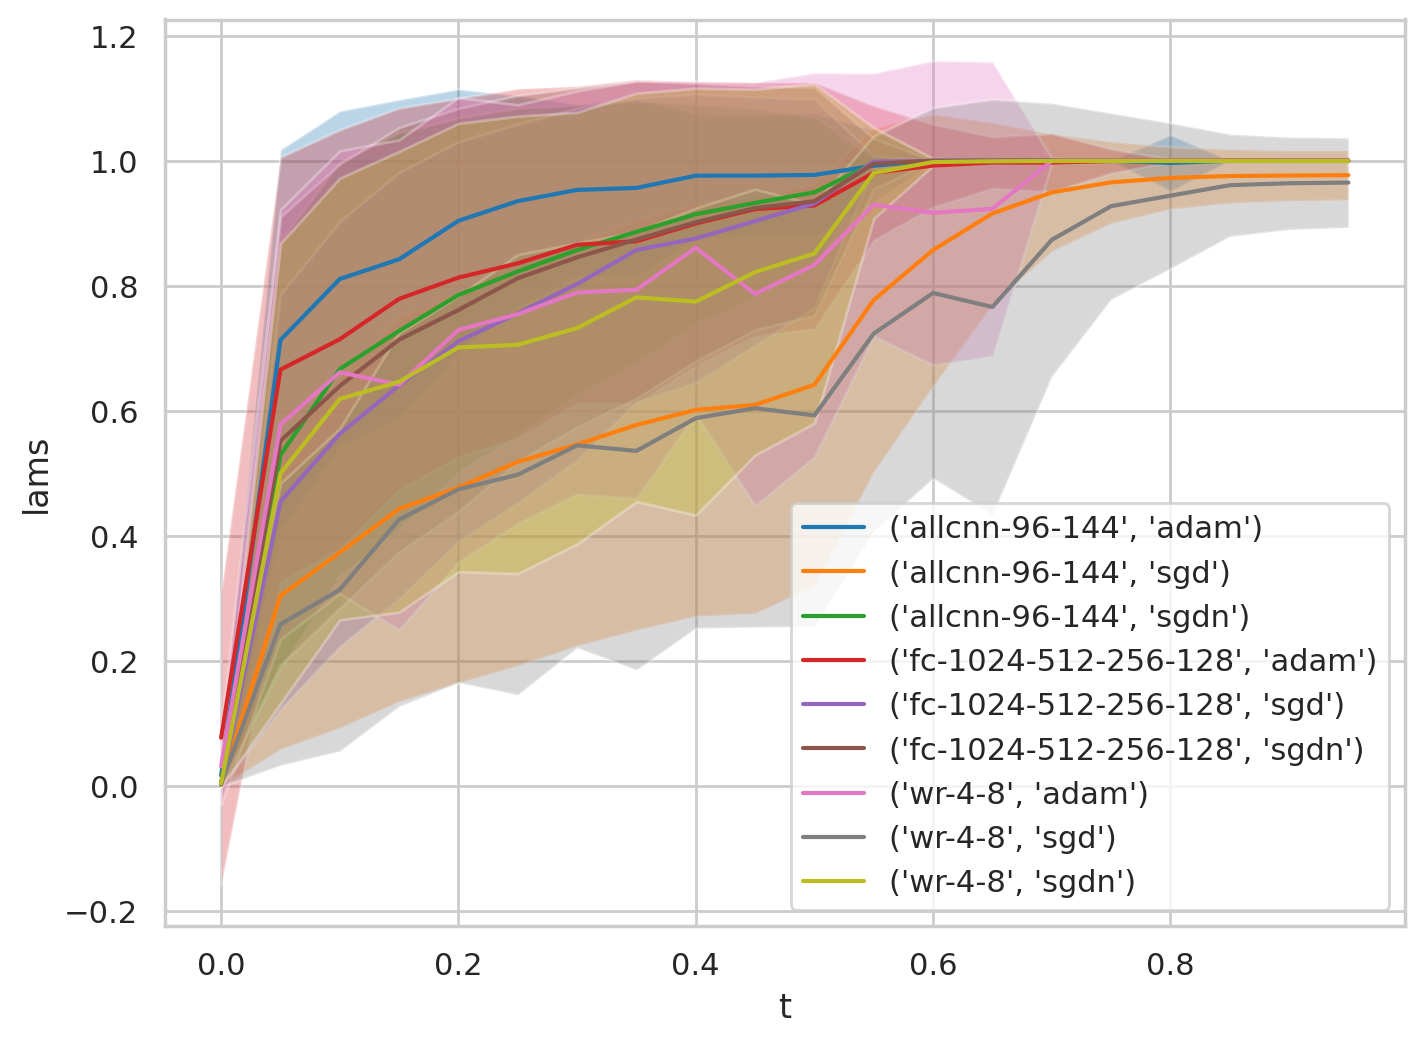

In [97]:
for config in idxs.keys():
    idx = idxs[config]
    di = d_.iloc[idx]
    ax=sns.lineplot(data=di, x='t', y='lams', label=str(config))
    plt.fill_between(di['t'], di['lams'] - di['std'], di['lams'] + di['std'], alpha=0.3)